# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

Dataset "messy-vs-clean-room" can be downloaded in Kaggle

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
#notes for myself of how to download datasets from kaggle to my VM in terminal

#mkdir ~/.kaggle

In [18]:
#!cp kaggle.json ~/.kaggle/
#!mv kaggle.json ~/.kaggle/kaggle.json

In [19]:
#!chmod 600 ~/.kaggle/kaggle.json

In [2]:
#!kaggle datasets list

In [1]:
#!cd /home/channing_platevoet/.kaggle
#!ls
#kaggle datasets download -d cdawn1/messy-vs-clean-room
#mv ~/messy-vs-clean-room.zip ~/work/course-v3/nbs/Projects/data/messy&tidy/messy-vs-clean-room.zip


### Create directory for downloaded images

In [3]:
path = Path('data/messy&tidy/images')

In [23]:
path.ls()

[PosixPath('data/messy&tidy/images/val'),
 PosixPath('data/messy&tidy/images/test'),
 PosixPath('data/messy&tidy/images/train')]

### Verify images

Then we can remove any images that can't be opened:

In [18]:
classes = ['clean','messy']

In [ ]:
for c in classes:
    print(c)
    verify_images(path/'train'/c, delete=True, max_size=500)

In [25]:
for c in classes:
    print(c)
    verify_images(path/'val'/c, delete=True, max_size=500)

clean


messy


## View data

In [4]:
bs = 64

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid='val',
        ds_tfms=get_transforms(), size=224, bs=bs, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [28]:
data.classes

['clean', 'messy']

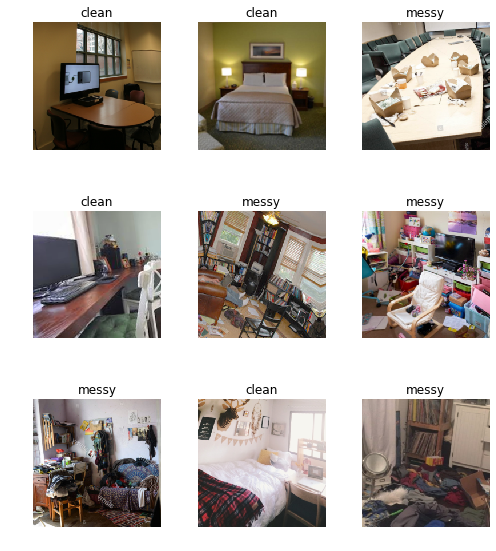

In [29]:
data.show_batch(rows=3, figsize=(7,8))

In [30]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['clean', 'messy'], 2, 192, 20)

## Train model

In [6]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.983261,0.644087,0.250000,00:05
1,0.636015,0.255437,0.100000,00:01
2,0.486536,0.239818,0.100000,00:01
3,0.415357,0.235935,0.100000,00:01


In [33]:
learn.save('stage-1')

In [34]:
learn.unfreeze()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


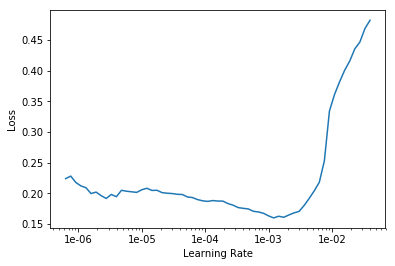

In [39]:
learn.recorder.plot()

In [46]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (192 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
clean,clean,clean,clean,clean
Path: data/messy&tidy/images;

Valid: LabelList (20 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
clean,clean,clean,clean,clean
Path: data/messy&tidy/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [47]:
learn.unfreeze()

In [48]:
learn.fit_one_cycle(4, max_lr=slice(1e-3,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.101829,0.799315,0.150000,00:01
1,0.174367,0.638372,0.100000,00:01
2,0.165271,1.057405,0.200000,00:01
3,0.139496,0.304174,0.050000,00:01


In [49]:
learn.save('stage-u')

## Interpretation

In [ ]:
#learn.load('stage-u');

In [50]:
interp = ClassificationInterpretation.from_learner(learn)

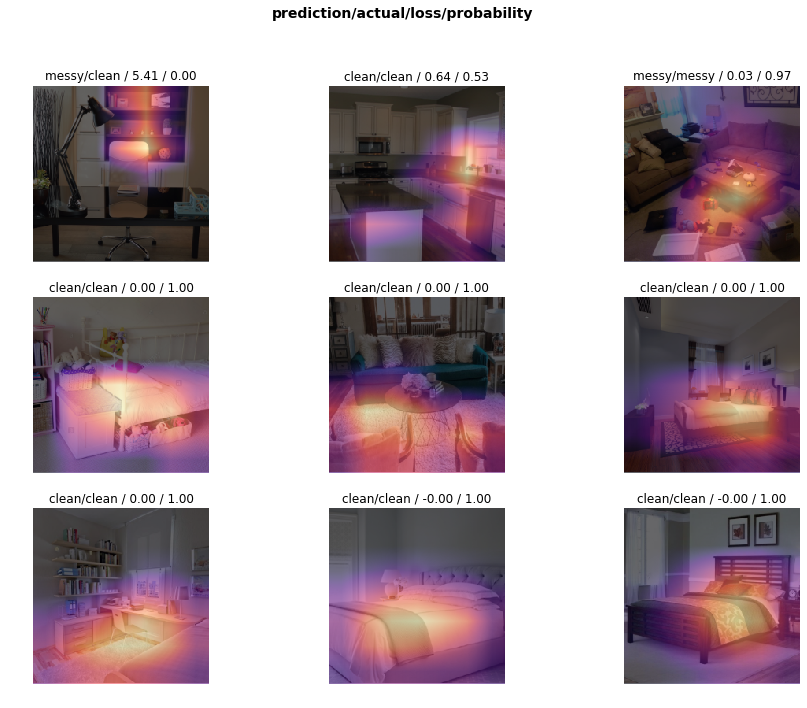

In [52]:
interp.plot_top_losses(9, figsize=(15,11))

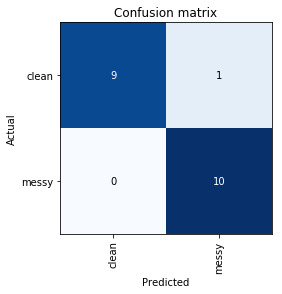

In [51]:
interp.plot_confusion_matrix()

In [51]:
# notes for myself
# different ways to import dataset using ImageDataBunch:
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
#df = pd.read_csv(path/'cleaned.csv', header='infer')

#data_cln = ImageDataBunch.from_csv(path, train="train", valid_pct=0.2,
#                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

# YANN:
#np.random.seed(42)
#df = pd.read_csv(pathdata/'clearned.csv', header='infer')
#db = (ImageList.from_df(df, pathdata)
#     .split_by_rand_pct(0.2)
#     .label_from_df()
#     .transform(get_transforms(), size=224)
#     .databunch(bs=64)).normalize(imagenet_stats)

np.random.seed(42)
data_cln = ImageDataBunch.from_csv(path, valid_pct=0.2,
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [7]:
learn.load('stage-u')

Learner(data=ImageDataBunch;

Train: LabelList (192 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
clean,clean,clean,clean,clean
Path: data/messy&tidy/images;

Valid: LabelList (20 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
clean,clean,clean,clean,clean
Path: data/messy&tidy/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [8]:
learn.export()

My production is in the following link:

https://japanese-standard.onrender.com/